__Autor__: Jesús Casado<br>
__Fecha__: 25-06-2020<br>

__Introducción__<br>
Se analiza la serie cincominutal de nivel de las posibles estaciones de aforo en el cierre de cada una de las cuencas de la C.H. Cantábrico.

__Índice__<br>
[Sistema EO](#Sistema-EO)<br>
[Sistema Porcía](#Sistema-Porcía)<br>
[Sistema Navia](#Sistema-Navia)<br>
[Sistema Esva](#Sistema-Esva)<br>
[Sistema Nalón](#Sistema-Nalón)<br>
[Sistema Villaviciosa](#Sistema-Villaviciosa)<br>
[Sistema Sella](#Sistema-Sella)<br>
[Sistema Llanes](#Sistema-Llanes)<br>
[Sistema Deva](#Sistema-Deva)<br>
[Sistema Nansa](#Sistema-Nansa)<br>
[Sistema Gandarilla](#Sistema-Gandarilla)<br>
[Sistema Saja](#Sistema-Saja)<br>
[Sistema Pas-Miera](#Sistema-Pas-Miera)<br>
[Sistema Asón](#Sistema-Asón)<br>
[Sistema Agüera](#Sistema-Agüera)<br>
[Sistema Nervión](#Sistema-Nervión)<br>
[Sistema Oria](#Sistema-Oria)<br>
[Sistema Urumea](#Sistema-Urumea)<br>
[Sistema Bidasoa](#Sistema-Bidasoa)<br>

In [37]:
import os
rutaBase = os.getcwd().replace('\\', '/') + '/'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(context='notebook', style='darkgrid')
import datetime
from tqdm import tqdm

In [38]:
def correctP(serie, thrP=30):
    """Convierte en NaN los datos de precipitación por encima de un umbral"""
    
    serie[serie > thrP] = np.nan
    
    return serie

In [39]:
def correctN(serie, dN_p=.2, dN_n=-0.05, window=48, f1=1.5, f2=.5, thrN=None, zeros=False, fill_method='ffill', **kwargs):
    """Corrige la serie de nivel en base a tres criterios:
        1. Se eliminan los datos con una tasa de cambio del nivel superior a 'dN_p' (aumento del caudal) o inferior a 'dN_n' (reducción del caudal)
        2. Se eliminan los datos inusuales frente a la media móvil de ancho 'window'
        3. Se eliminan los valores por encima del umbral 'thrN'
        4. Se eliminan los valores negativos (y los nulos en caso de 'zeros=True')
        
    Entradas:
    ---------
    serie:       data frame. Serie original de nivel
    dN_p:        float. Tasa de cambio máxima (positiva) aceptada en las crecidas
    dN_n:        float. Tasa de cambio máxima (negativa) aceptada en las recesiones
    window:      int. Ancho de la ventana móvil
    f1:          float. Factor aceptado por encima de la mediana móvil
    f2:          float. Factor aceptado por debajo de la mediana móvil
    thrN:        float. Máximo valor de nivel aceptado. Por defecto (None) no se aplica esta corrección
    zeros:       boolean. Si se acepta la existencia de ceros o no. Por defecto no se aceptan (False)
    fill_method: string. Método de completado de los huecos: 'ffil', forward filling; 'bfil', backward filling. Si es 'None', no se rellenan los huecos
    kwargs:      otros argumnetos
    
    Salida:
    -------
    serie_:      data frame. Serie de nivel corregida
    """
    
    serie_ = serie.copy()
    
    # 1. DATOS CON UNA TASA DE CAMBIO EXCESIVA
    # serie de diferencias de nivel
    diff = serie_.diff(1)
    # identificar tasas de cambio excesivas
    idxs = serie_[(diff > 0.2) | (diff < -0.05)].index
    # eliminar pasos con tasa de cambio excesiva
    serie_[idxs] = np.nan
#     # analizar el entorno de los casos problemáticos
#     i = 0
#     while i < len(idxs):
#         idx1 = idxs[i]
#         for idx2 in idxs[i + 1:]:
#             if (idx2 - idx1).days > 7:
#                 break
#             else:
#                 i += 1
#         # corregir en base a la mediana de los pasos anteriores
#         for time in pd.date_range(idx1, idx2, freq='5min'):
#             temp = serie_[:time]
#             temp.dropna(inplace=True)
#             median = np.nanmedian(temp.iloc[-w:])
#             if (serie_[time] > median * f1) | (serie_[time] < median * f2):
#                 serie_[time] = np.nan
#         i += 1
    # rellenar los huecos
    if fill_method is not None:
        serie_.fillna(method=fill_method, limit=kwargs.get('limit', 6 * 12), inplace=True)
    
    # 2. VALORES INUSUALES SOBRE LA MEDIANA MÓVIL
#     # eliminar crecidas con valores superiores a 'f1' la mediana móvil del periodo anterior
#     median = serie_.rolling(window, min_periods=int(np.ceil(window/10)), center=False).median()
#     serie_[serie_ > median * f1] = np.nan
#     # eliminar recesiones con un exponente inferior a 'f2'
#     median = serie_.rolling(window, center=False).median()
#     serie_[serie_ < median * f2] = np.nan
#     # rellenar los huecos
#     if fill_method is not None:
#         serie_.fillna(method=fill_method, limit=kwargs.get('limit', 6 * 12), inplace=True)

#     for time in serie_.index:
#         temp = serie_[:time]
#         temp.dropna(inplace=True)
#         median = np.nanmedian(temp.iloc[-window:])
#         if (serie_[time] > median * f1) | (serie_[time] < median * f2):
#             serie_[time] = np.nan
    
    # 3. DATOS POR ENCIMA DE UN UMBRAL
    serie_[serie_ > thrN] = np.nan
    # rellenar los huecos
    if fill_method is not None:
        serie_.fillna(method=fill_method, limit=kwargs.get('limit', 6 * 12), inplace=True)
    
    # 4. DATOS NEGATIVOS (Y NULOS)
    if zeros:
        serie_[serie_ < 0] = np.nan
    else:
        serie_[serie_ <= 0] = np.nan 
    # rellenar los huecos
    if fill_method is not None:
        serie_.fillna(method=fill_method, limit=kwargs.get('limit', 6 * 12), inplace=True)
    
    return serie_

In [40]:
def alertaNivel(estacion, out=False, export=True, correct=True, **kwargs):
    """Carga los datos del SAIH de la estación, extrae los datos de nivel y genera un gráfico que compara la serie de nivel frente a los umbrales de alerta.
    """
    
    # importar umbrales de alerta
    rutaUmbrales = 'K:/Scripts/'
    umbrales = pd.read_csv(rutaBase + 'Umbrales de alerta.csv', index_col='COD_SAIH', encoding='latin-1')

    # importar datos observados
#     rutaData = 'K:/Series/SAIH-CHC/5min/'
    rutaData = 'C:/Users/jcasado4/OneDrive - UNICAN/Series/CHC/SAI/SAI-CHC/Series/5min/'
    data = pd.read_csv(rutaData + estacion + '.csv', parse_dates=True, index_col='Fecha', encoding='latin-1')
    cols = [col for col in ['nivel_m', 'caudal_m³/s', 'precipitacion_mm'] if col in data.columns]
    data = data[cols]
    st, en = data.first_valid_index(), data.last_valid_index()
    print('{0}\t{1}'.format(st, en))
    data = data[st:en]
    
    # corregir datos
    if correct:
        if 'precipitacion_mm' in data.columns:
            data.precipitacion_mm = correctP(data.precipitacion_mm, thrP=kwargs.get('thrP', 30))
        if 'nivel_m' in data.columns:
            data.nivel_m = correctN(data.nivel_m, thrN=kwargs.get('thrN', 30), dN_p=kwargs.get('dN_p', 0.2), dN_n=kwargs.get('dN_n', -0.05), window=kwargs.get('window', 48),
                                    f1=kwargs.get('f1', 1.5), f2=kwargs.get('f2', .5), fill_method=kwargs.get('fill_method', 'ffill'))
            
    # gráfico de la serie de nivel
    fig = plt.figure(figsize=(22, 4))
    gs = fig.add_gridspec(1, 5)
    e = kwargs.get('e', 50)
    r1 = kwargs.get('r1', 10)
    r2 = kwargs.get('r2', 10)
    r3 = kwargs.get('r3', 100)
    cmap = kwargs.get('cmap', 'winter_r')
    date1 = datetime.date(st.year, st.month, 1)
    date2 = datetime.date(en.year, en.month + 1, 1) if en.month < 12 else datetime.date(en.year + 1, 1, 1)
    xlim = kwargs.get('xlim', (date1, date2))

    ax1 = fig.add_subplot(gs[0, 1:])
        
    if 'precipitacion_mm' in data.columns:
        axP = ax1.twinx()
        axP.grid(None)
        axP.tick_params(length=0)
        Pmax = np.ceil(data['precipitacion_mm'].max() / r2) * r2
        Perr = Pmax / e
        axP.set(ylim=(Pmax + Perr, - Perr), ylabel='precipitación (mm)')
        Pticks = np.linspace(0, Pmax, 6).astype('int')
        axP.set_yticks(Pticks)
        axP.set_yticklabels(Pticks)
        axP.plot(data['precipitacion_mm'], c='dimgray', lw=.2, label='precipitación (mm)')
        
    # umbrales de alerta
    Nalerta = pd.DataFrame(columns=['Amarilla', 'Naranja', 'Roja'], index=pd.date_range(st, en, freq='5min'))
    for alerta, c in zip(Nalerta.columns, ['yellow', 'orange', 'r']):
        Nalerta[alerta] = umbrales.loc[estacion, alerta]
        ax1.plot(Nalerta[alerta], c=c, label='alerta {0}'.format(alerta.lower()))
    # serie de nivel
#     ax1.plot(data['nivel_m'], lw=1, label='nivel (m)', zorder=10)
    ax1.scatter(data.index, data['nivel_m'], s=.001, c=data.index, cmap=cmap, label='nivel (m)', zorder=10)
    # config
    ax1.tick_params(length=0)
    Nmax = np.ceil(data['nivel_m'].max() / r1) * r1
    Nerr = Nmax / e
    Nticks = np.linspace(0, Nmax, 6).astype('int')
    ax1.set(xlim=xlim, ylim=(-Nerr, Nmax + Nerr), xlabel='fecha', yticks=Nticks, yticklabels=[])    

    
    if 'caudal_m³/s' in data.columns:
        ax2 = fig.add_subplot(gs[0, 0])
        ax2.tick_params(length=0)
        Qmax = np.ceil(data['caudal_m³/s'].max() / r3) * r3
        Qerr = Qmax / e
        ax2.set(xlim=(-Qerr, Qmax + Qerr), xlabel='caudal (m³/s)', ylim=(-Nerr, Nmax + Nerr), ylabel='N (m)', yticks=Nticks)
        # umbrales de alerta
        Nalerta = pd.DataFrame(columns=['Amarilla', 'Naranja', 'Roja'], index=[0, Qmax])
        for alerta, c in zip(Nalerta.columns, ['yellow', 'orange', 'r']):
            Nalerta[alerta] = umbrales.loc[estacion, alerta]
            ax2.plot(Nalerta[alerta], c=c, label='alerta {0}'.format(alerta.lower()), zorder=1)
        # curva de gasto
        ax2.scatter(data['caudal_m³/s'], data['nivel_m'], s=.1, c=data.index, cmap=cmap, alpha=.75, zorder=2)
    else:
        ax1.set(ylabel='nivel (m)', yticklabels=Nticks)
    
    fig.text(.5, .925, 'Sistema {0} - río {1} - estación {2}'.format(*umbrales.loc[estacion, ['Sistema', 'Río']], estacion), fontsize=14,
              fontweight='bold', horizontalalignment='center')
    
    # exportar gráfico
    if export:
        plt.savefig(rutaUmbrales + 'Gráficos nivel/Serie nivel ' + estacion + '.png', dpi=500, bbox_inches='tight')
    
    # salida
    if out:
        if 'xlim' in kwargs:
            st, en = kwargs['xlim']
            return data[st:en]
        else:
            return data

### Sistema EO
Estación A048 en San Tirso de Abres.

In [85]:
data

,nivel_m,caudal_m³/s,precipitacion_mm
Fecha,,,
2008-10-28 13:25:00,0.60,6.93,NaN
2008-10-28 13:30:00,0.61,7.16,NaN
2008-10-28 13:35:00,0.60,6.93,NaN
2008-10-28 13:40:00,0.60,6.93,NaN
2008-10-28 13:45:00,0.60,6.93,NaN
...,...,...,...
2019-05-31 23:35:00,0.62,9.66,0.0
2019-05-31 23:40:00,0.62,9.66,0.0
2019-05-31 23:45:00,0.62,9.66,0.0


In [114]:
data = data.loc[:, ['caudal_m³/s', 'nivel_m']]
data.loc[data['caudal_m³/s'] == 0, 'caudal_m³/s'] = np.nan
data.dropna(how='any', inplace=True)

In [115]:
sum(data['caudal_m³/s'] == 0), sum(data['nivel_m'] == 0)

(0, 0)

In [123]:
sum(data['caudal_m³/s'] <= 0), sum(data['nivel_m'] <= 0)

(0, 0)

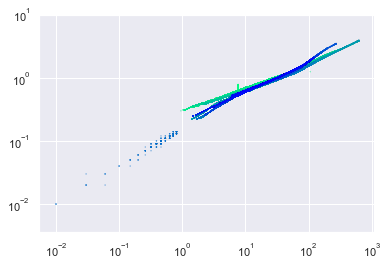

In [127]:
fig, ax = plt.subplots()
ax.scatter(data['caudal_m³/s'], data['nivel_m'], s=.1, c=data.index, cmap=cmap, alpha=.75, zorder=2)
ax.axis('equal')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set(xscale='log', yscale='log')

2008-10-28 13:25:00	2019-05-31 23:55:00


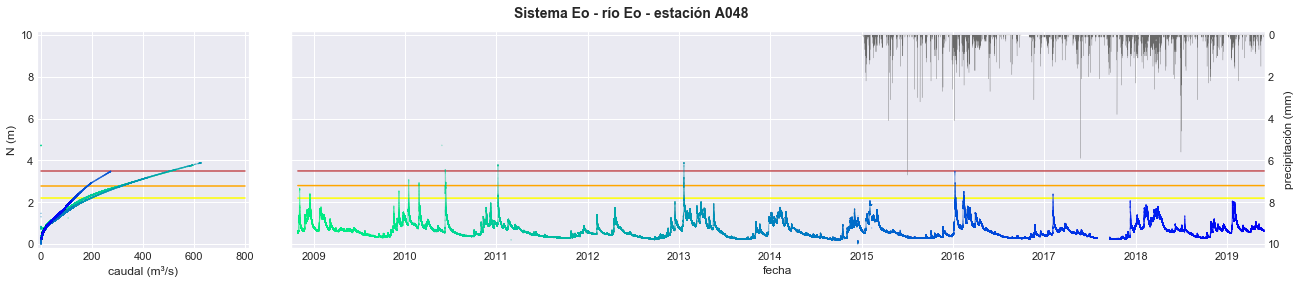

In [75]:
A048 = alertaNivel('A048', correct=True, out=True, r3=200, thrN=6, dN_n=-0.05, window=12*24, fill_method=None)#, xlim=(datetime.date(2014, 12, 1), datetime.date(2014, 12, 20)))

2008-07-01 00:00:00	2019-05-31 23:55:00


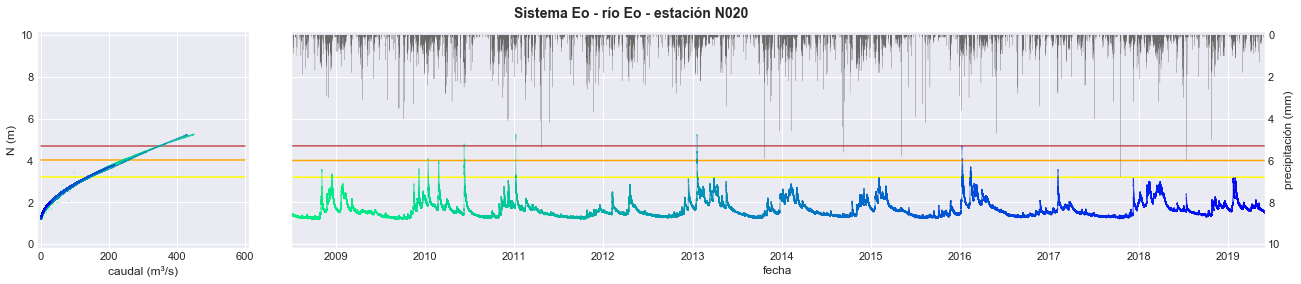

In [42]:
N020 = alertaNivel('N020', out=True, r3=200, fill_method=None, cmap='winter_r')

2007-10-01 00:00:00	2019-05-31 23:55:00


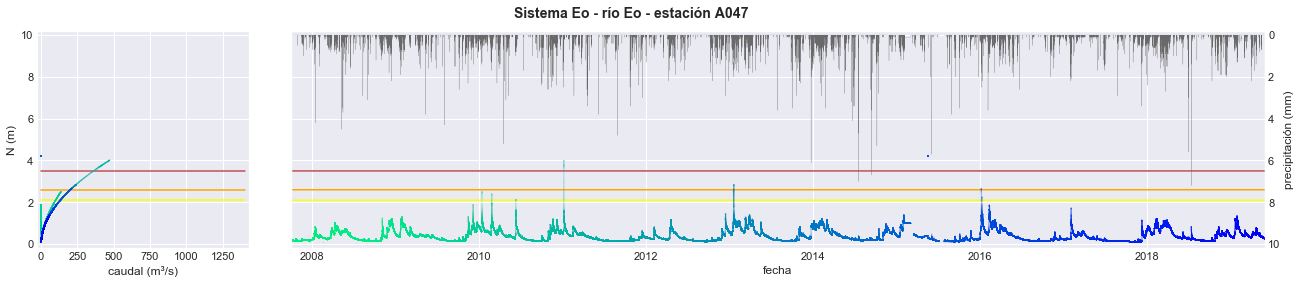

In [43]:
A047 = alertaNivel('A047', out=True, r3=200, thrN=6, fill_method=None)

En el periodo entre 2009 y 2019 se identifican 10 eventos: 4 de alerta amarilla, 4 naranja y 2 roja

### Sistema Porcía
Estación A613 en Sueiro (El Franco).

2009-12-23 22:50:00	2019-05-31 23:55:00


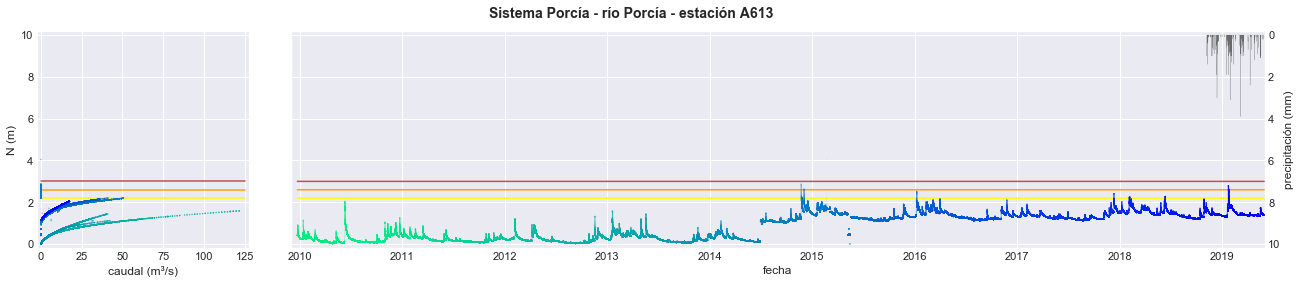

In [44]:
A613 = alertaNivel('A613', correct=True, out=True, r3=25, window=24*12, fill_method=None)#, xlim=(datetime.date(2015, 5, 1), datetime.date(2015, 6, 1)))

7 eventos: 1 de nivel rojo, 2 naranja y 4 amarillo.

### Sistema Navia
<font color='red'>¿Estación A610 en San Antolín (Ibias)?</font>

2010-03-12 11:45:00	2019-05-31 23:55:00


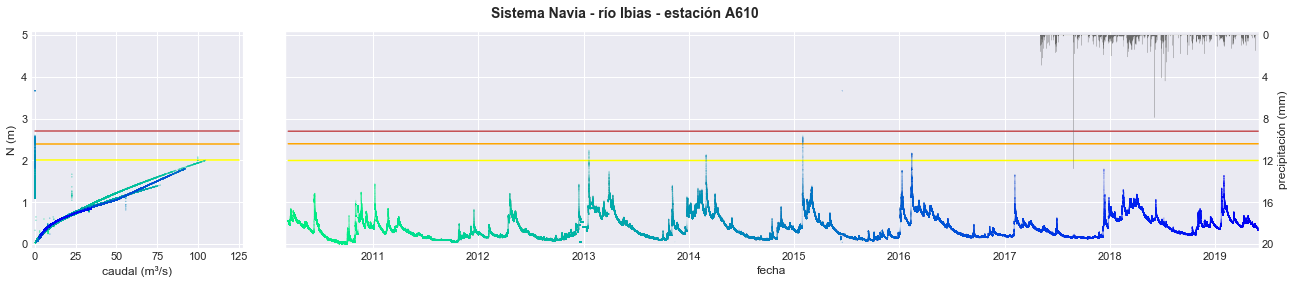

In [84]:
alertaNivel('A610', r1=5, r3=25, thrN=5, fill_method=None)

En el perido 2010-2019 se identifican 4 eventos: 1 de alerta naranja y 3 amarilla.

### Sistema Esva
#### Río Negro
Estación A053 en Luarca.

2010-03-19 10:25:00	2019-05-31 23:55:00


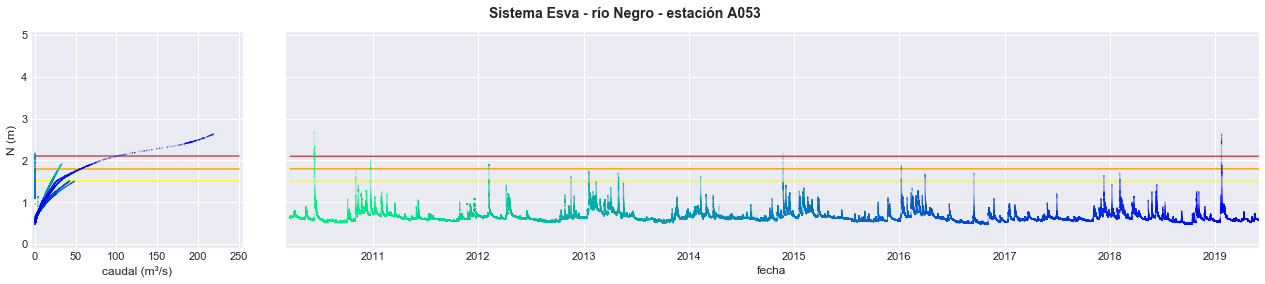

In [46]:
alertaNivel('A053', r1=5, r3=50, fill_method=None)

Entre 2010 y 2019 se identifican 16 eventos: 3 de alerta roja, 4 de alerta naranja y 9 amarilla.

#### Río Esva
Estación A609 en Trevías (Valdés).

2008-10-28 13:25:00	2019-05-31 23:55:00


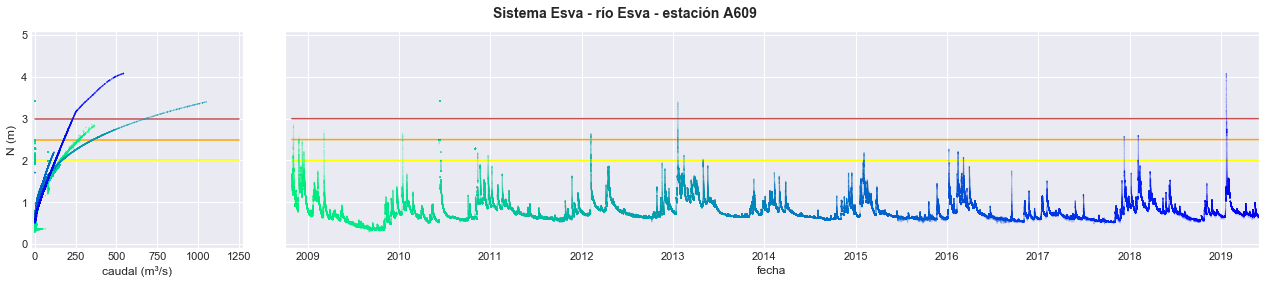

In [47]:
alertaNivel('A609', r1=5, r3=250, fill_method=None)

Entre 2008 y 2019 se dieron 21 eventos: 3 de alarma roja, 9 naranja y 9 amarilla.

### Sistema Nalón
#### Río Narcea
Estación Q103 en Quinzanas (Pravia).

2009-03-25 10:50:00	2019-05-31 23:55:00


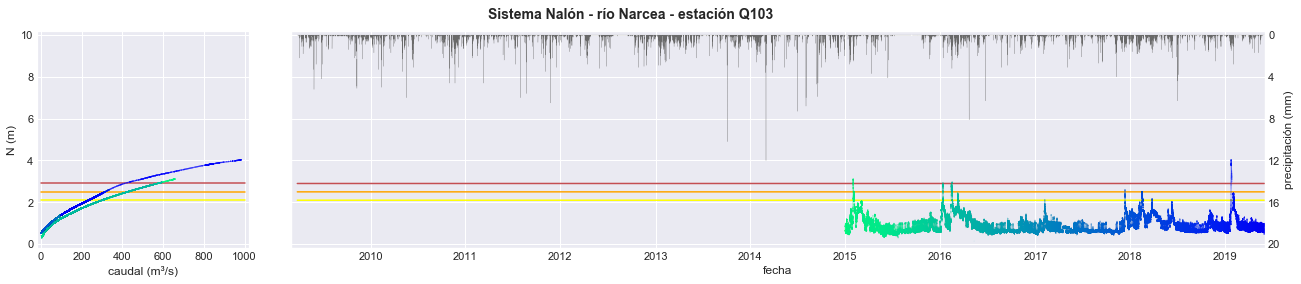

In [48]:
alertaNivel('Q103', fill_method=None)

De 2015 a 2019 se dieron 9 eventos: 4 de nivel rojo, 2 de nivel naranja y 3 amarillo.

#### Río Nalón
Estación Q102 en Grullos (Cándamo).

2008-07-31 15:45:00	2019-05-31 23:55:00


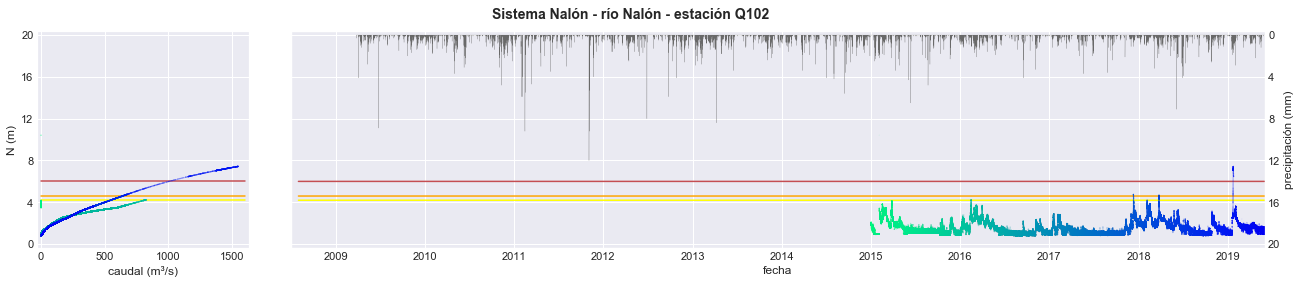

In [49]:
alertaNivel('Q102', thrP=20, fill_method=None)

4 eventos: 1 alerta roja, dos naranja y una amarilla.

#### Río Raíces
Estación N030 en Salinas.

2017-10-19 18:05:00	2019-05-31 23:55:00


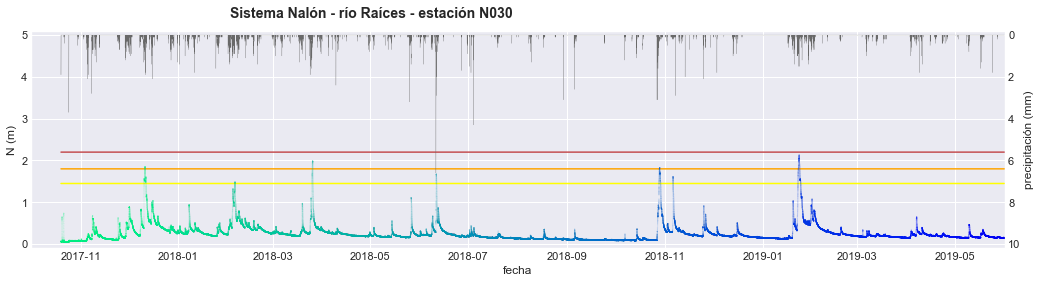

In [74]:
alertaNivel('N030', r1=5, fill_method=None)

7 eventos: 4 de nivel naranja y 3 amarillo.

### Sistema Villaviciosa
Estación A623 en Villaviciosa.

2012-04-09 18:20:00	2019-05-31 23:55:00


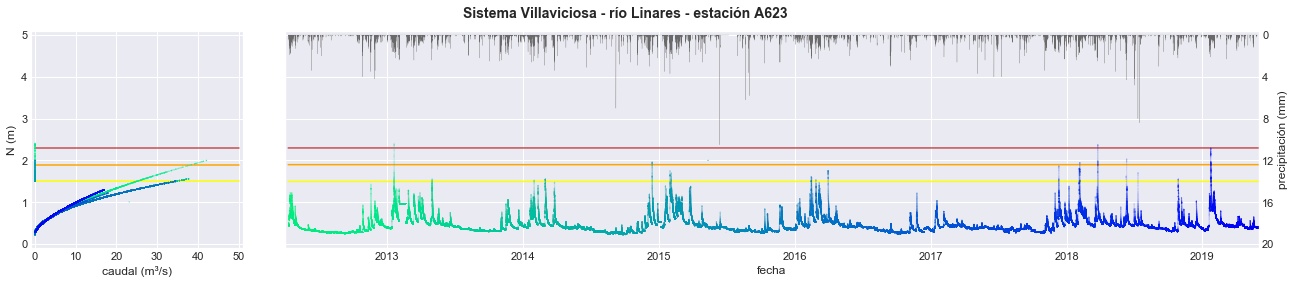

In [51]:
alertaNivel('A623', r1=5, r3=50, fill_method=None)

Entre 2012 y 2019 se dieron 18 eventos: 2 de nivel rojo, 4 naranja y 12 amarilla.

### Sistema Sella
Estación Q101 en Arriondas

2010-01-29 14:00:00	2019-05-31 23:55:00


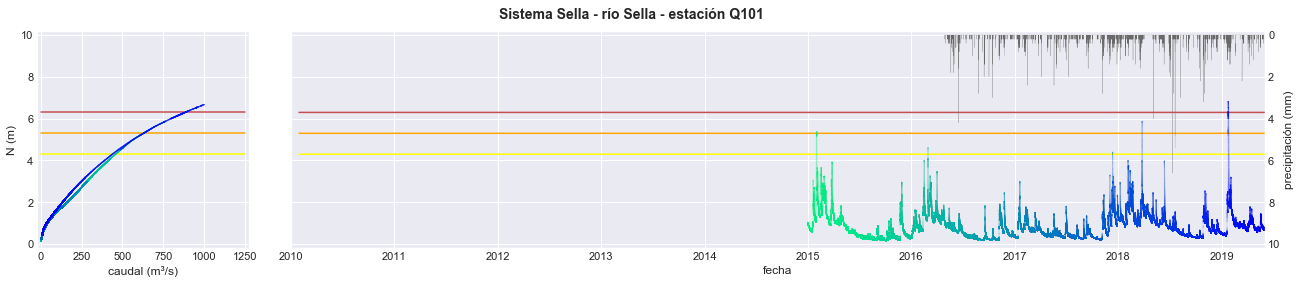

In [52]:
data = alertaNivel('Q101', out=True, r3=250, thrP=8, fill_method=None)

A simple vista, entre 2015 y 2019 se identifican 5 eventos en los que se alcanzó algún nivel de alerta: 1 evento con alarma rojo, 2 naranja y 2 amarilla

### Sistema Llanes
#### Río Ereba
Estación A619 en Nueva de Llanes.

2011-11-15 18:40:00	2019-05-31 23:55:00


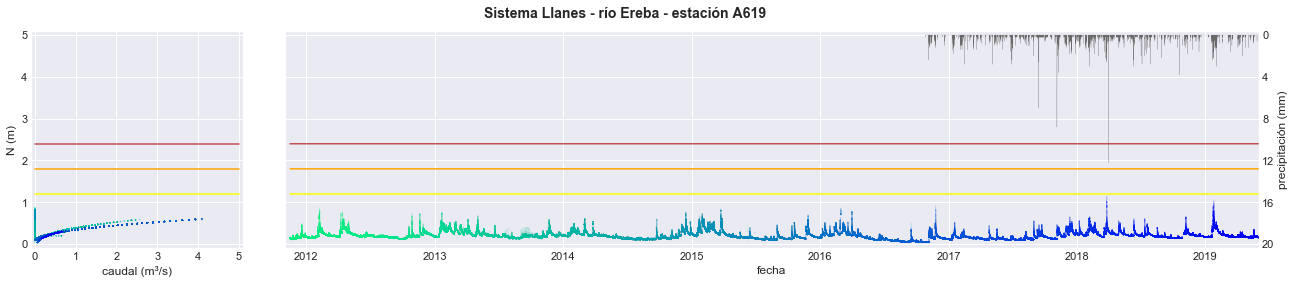

In [53]:
alertaNivel('A619', r1=5, r3=5, fill_method=None)

0 eventos

#### Río Bedón
Estación A074 en Rales (Llanes).

2008-10-28 13:25:00	2019-05-31 23:55:00


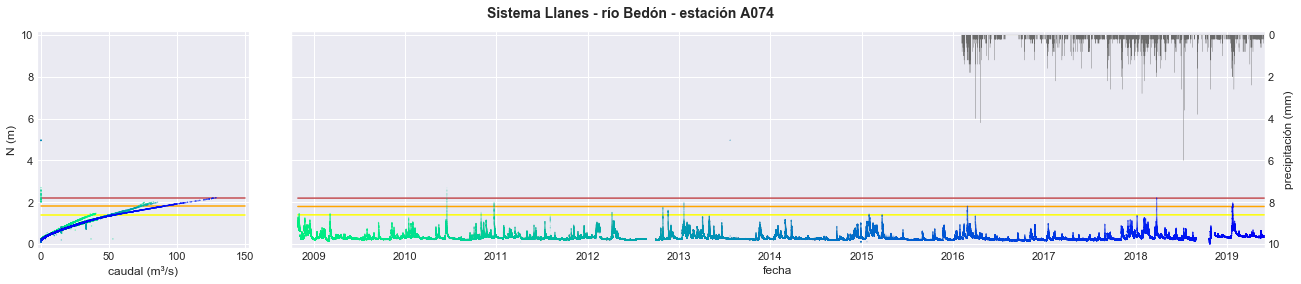

In [54]:
alertaNivel('A074', r3=25, fill_method=None)

De finales de 2008 a mediados de 2019, se identifican 14 eventos: 2 de alerta roja, 4 naranja y 8 amarilla.

### Sistema Deva
Estación A617 en Panes (Peñamellera Baja).

2011-02-24 12:05:00	2019-05-31 23:55:00


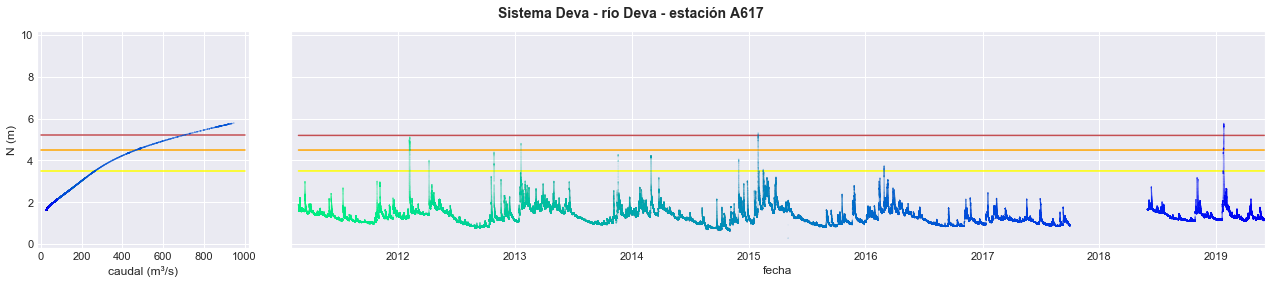

In [55]:
alertaNivel('A617', fill_method=None)

De 2011 a 2020 se registraron 11 eventos: 2 de alerta rjoa, 3 naranja y 6 amarilla.

### Sistema Nansa
Estación A252 en Puente Pumar (Polaciones).

2014-07-18 15:20:00	2019-05-31 23:55:00


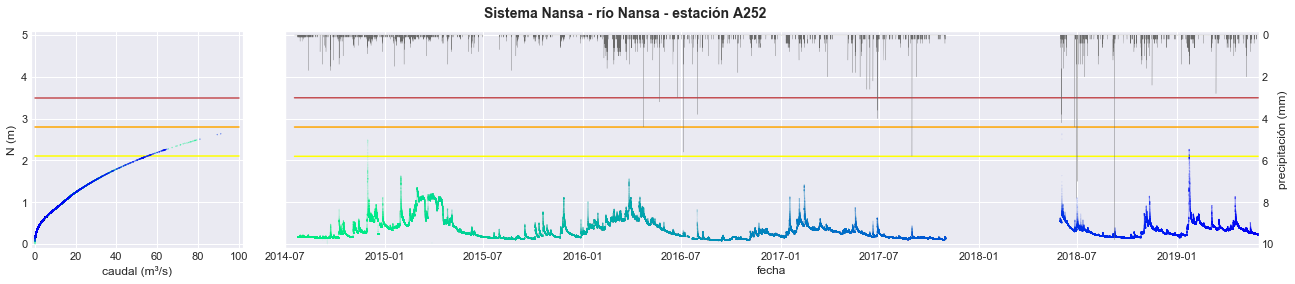

In [56]:
alertaNivel('A252', r1=5, fill_method=None)

4 eventos de alarma amarilla entre finales de 2014 y mediados de 2015.

### Sistema Gandarilla
Estación N078 eb Roiz (Valdáliga).

2011-11-10 17:05:00	2019-05-31 23:55:00


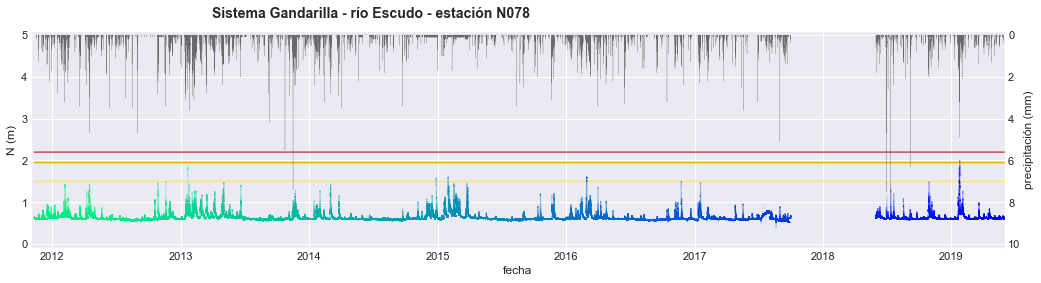

In [57]:
alertaNivel('N078', r1=5, fill_method=None)

7 eventos: 3 de alarma roja, 1 naranja y 3 amarilla.

### Sistema Saja
#### Río Saja
Estación Q106 en Torrelavega.

2008-11-01 00:05:00	2019-05-31 23:55:00


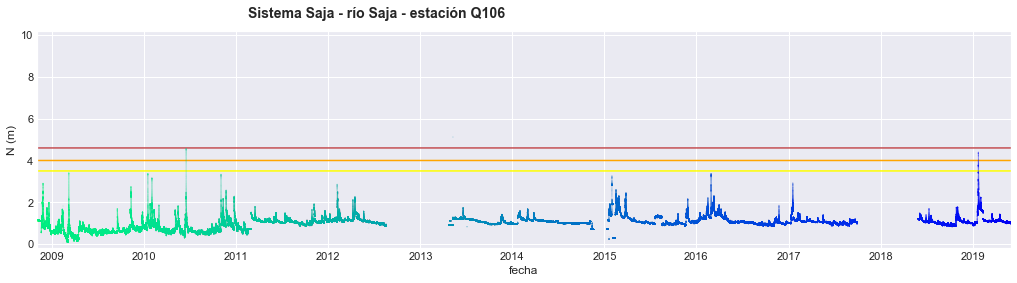

In [73]:
alertaNivel('Q106', thrN=6, r1=5, fill_method=None)

Claramente identificables 2 eventos de nivel naranja. Existen otros 3 eventos con picos de dudosa veracidad.

Estación E055 en Puente San Miguel.

2011-10-28 11:40:00	2019-05-31 23:55:00


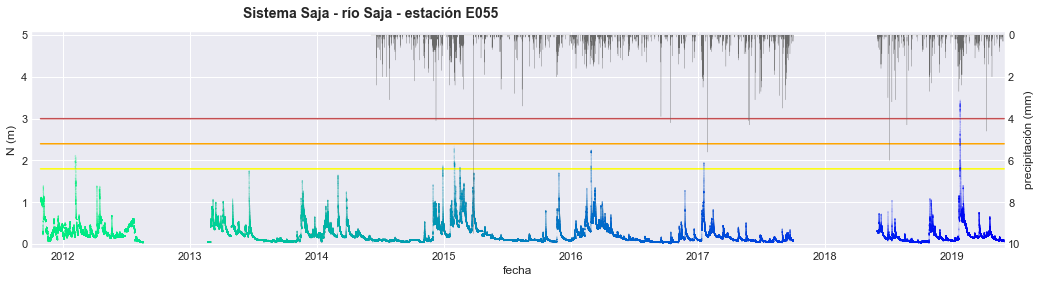

In [59]:
alertaNivel('E055', r1=5, fill_method=None)

7 eventos: 1 de nivel rojo y 6 amarillo.

#### Río Besaya
Estación N038 en Puente de Torres

2008-10-28 13:25:00	2019-05-31 23:55:00


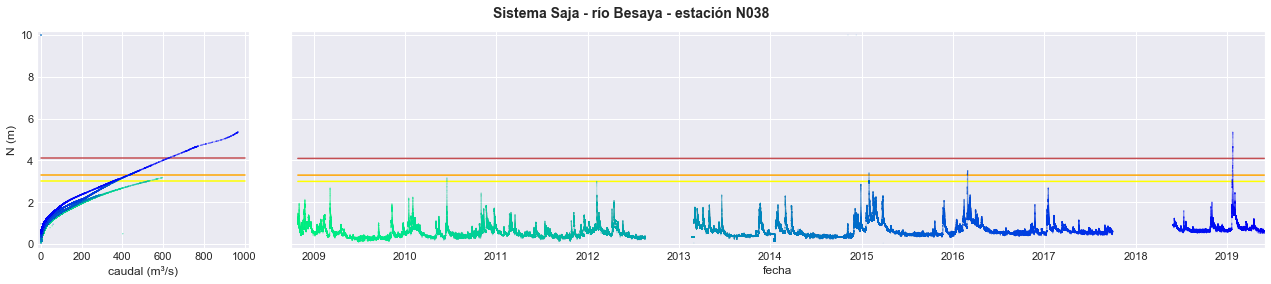

In [60]:
alertaNivel('N038', fill_method=None)

4 eventos identificables: 1 de nivel rojo, 2 naranja y 1 amarillo.

### Sistema Pas-Miera
#### Río Pas
Estación Q104 en Carandia (Piélagos).

2009-03-31 15:25:00	2019-05-31 23:55:00


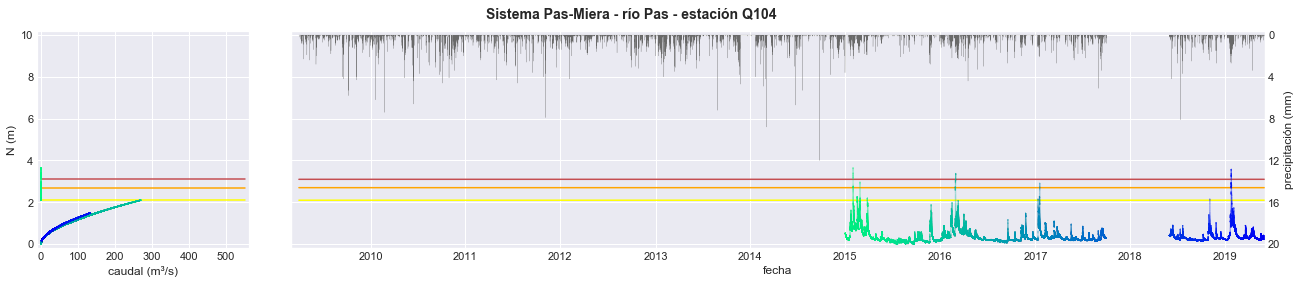

In [61]:
alertaNivel('Q104', r3=50, fill_method=None)

8 eventos: 3 de nivel rojo, 2 naranja y 2 amarilo.

#### Río Miera
Estación Q118 en Puente Agüero (Entrambasaguas).

2009-04-01 14:10:00	2019-05-31 23:55:00


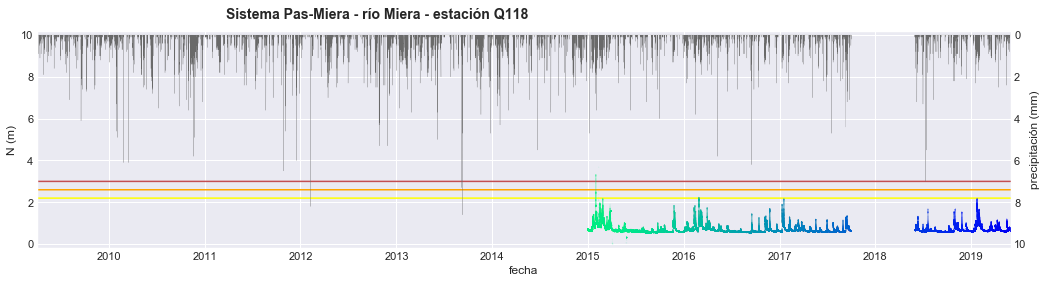

In [62]:
alertaNivel('Q118', fill_method=None)

4 eventos identificables: 3 de nivel rojo y 1 amarillo.

### Sistema Asón
Estación A701 en Coterillo (Ampuero).

2008-10-28 13:25:00	2019-05-31 23:55:00


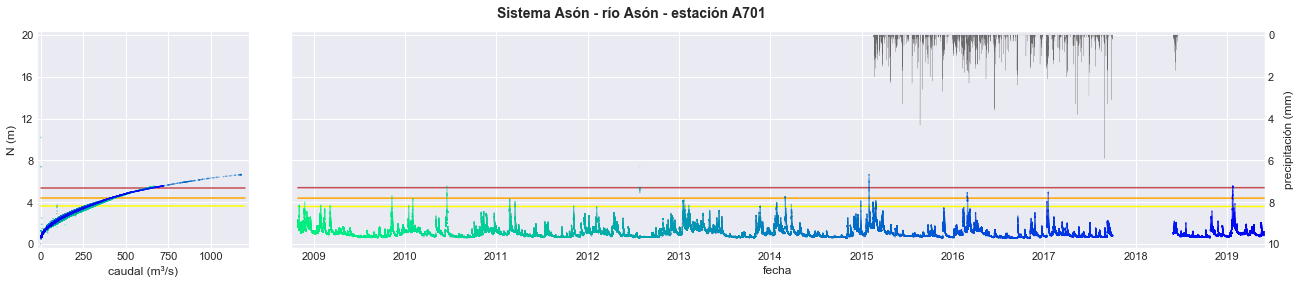

In [63]:
alertaNivel('A701', fill_method=None)

24 eventos: 2 de nivel rojo, 4 naranja y 18 amarillo.

### Sistema Agüera
Estación A700 en Guriezo.

2008-10-28 13:25:00	2019-05-31 23:55:00


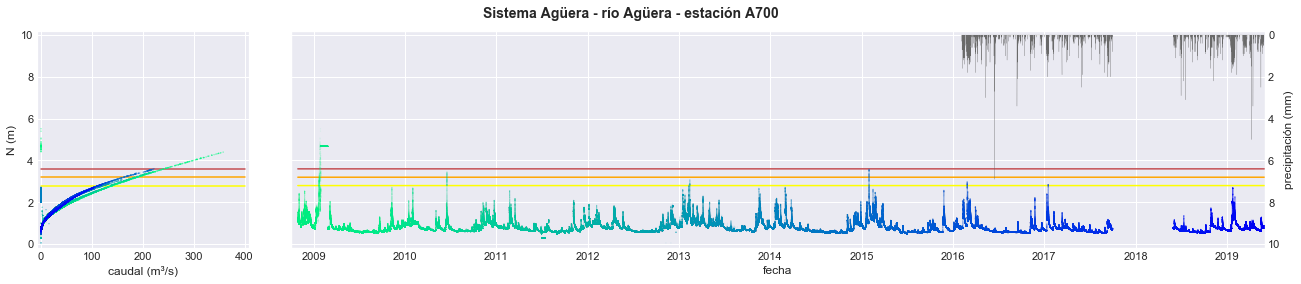

In [64]:
alertaNivel('A700', fill_method=None)#, out=True, xlim=(datetime.date(2015, 1, 1), datetime.date(2015, 2, 1)))

7 eventos: 2 de nivel rojo, 1 naranja y 4 amarillo.

### Sistema Nervión
#### Río Cadagua
Estación Q117 en Alosotegui.

2009-04-28 16:40:00	2019-05-31 23:55:00


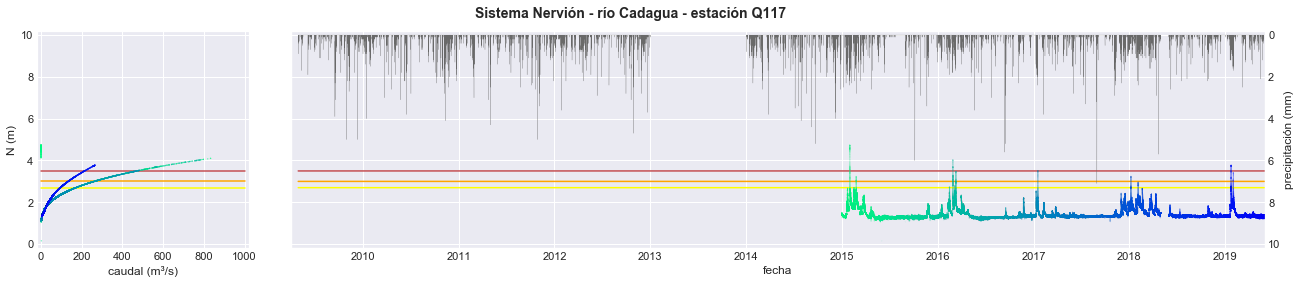

In [65]:
dataN = alertaNivel('Q117', r3=200, fill_method=None)#, out=True, xlim=(datetime.date(2015, 2, 15), datetime.date(2015, 2, 22)))

8 eventos: 4 de nivel rojo, 2 naranja y 2 amarillo.

#### Río Nervión
Estación Q116 en La Peña (Arrigorriaga).

2009-05-20 12:50:00	2019-05-31 23:55:00


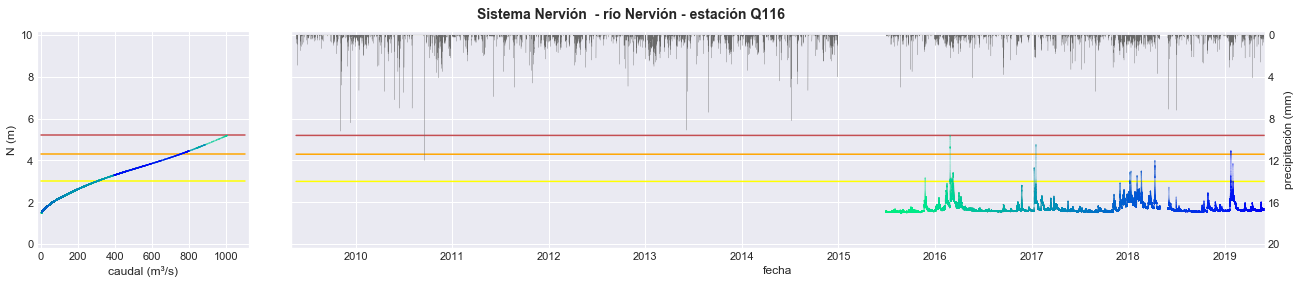

In [66]:
dataN = alertaNivel('Q116', out=True, fill_method=None)#, xlim=(datetime.date(2016, 2, 1), datetime.date(2016, 4, 1)))

7 eventos: 1 de nivel rojo, 2 naranja y 4 amarillo.

### Sistema Oria
Estación A149 en Andoain.

2009-12-14 18:15:00	2019-05-31 23:55:00


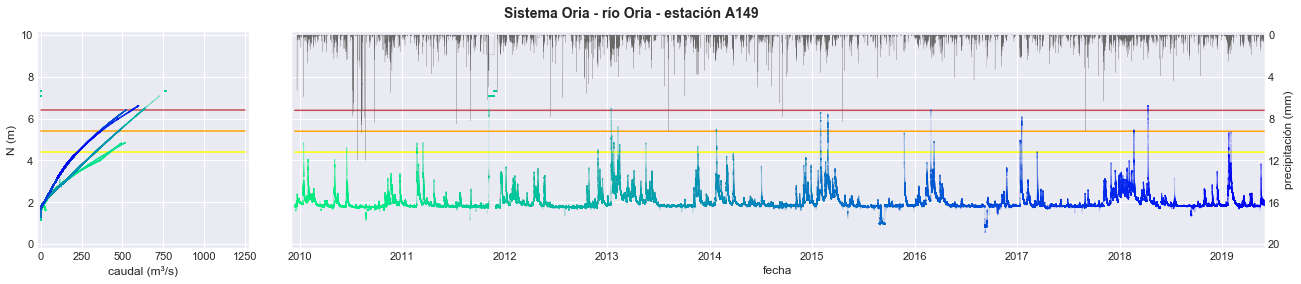

In [71]:
alertaNivel('A149', r3=250, thrN=8, fill_method=None)

12 eventos identificables: 6 de nivel amarillo, 3 naranja y 3 rojo.

### Sisema Urumea
Estación Q115 en Ergobia (Astigarraga).

2010-12-22 11:40:00	2019-05-31 23:55:00


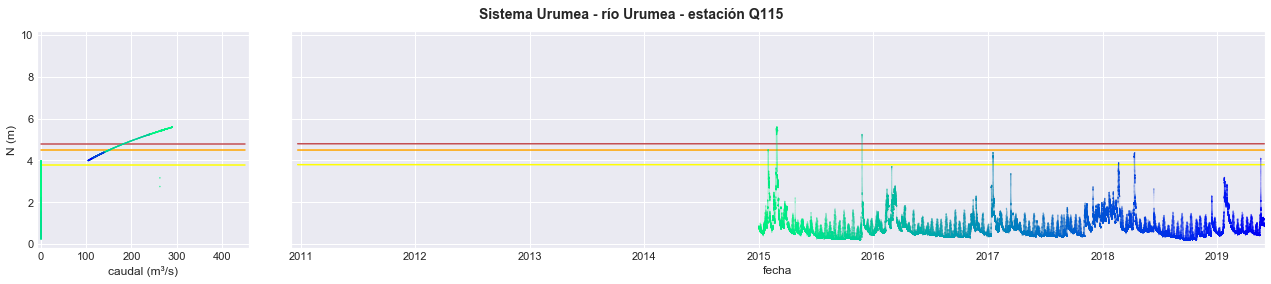

In [68]:
alertaNivel('Q115', r3=50, fill_method=None)#, xlim=(datetime.date(2017, 1, 1), datetime.date(2017, 1, 3)))

7 eventos: 2 de nivel rojo, 1 naranja y 4 amarillo.

### Sistema Bidasoa
Estación A140 en Endarlatsa (Irún).

2009-05-13 18:00:00	2019-05-31 23:55:00


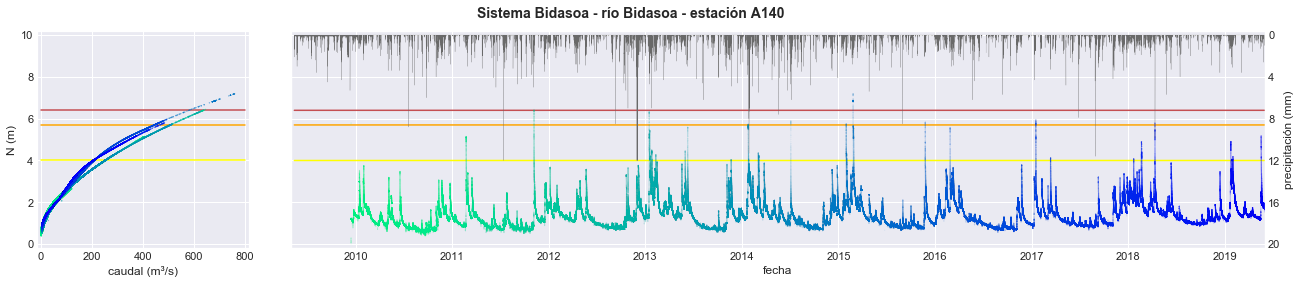

In [70]:
alertaNivel('A140', thrN=8, fill_method=None)

19 eventos: 3 de nivel rojo, 7 naranja, 9 amarillo.